In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import scipy.optimize as opt
import pickle
pd.options.display.max_seq_items = 2000

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

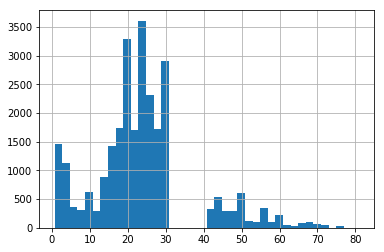

In [4]:
df['avg_price'].hist(bins=40)

In [5]:
data=df['avg_price'].values

In [6]:
data = data[np.isfinite(data)]

In [7]:
data

array([29.95, 27.95, 27.95, ..., 15.9 , 24.5 , 24.95])

Will estimate sales for the missing band using a poisson distribution

In [23]:
from scipy.misc import factorial
from scipy.optimize import minimize, curve_fit

def poisson(k, paras):#paras[0]=lambda, paras[1]=shift, paras[2]=Amplitude
    """poisson pdf, parameter lamb is the fit parameter"""
    return paras[2]*(paras[0]**(k+paras[1])/factorial(k+paras[1])) * np.exp(-paras[0])
def negLogLikelihood(params, data):
    """ the negative log-Likelohood-Function"""
    lnl = - np.sum(np.log(poisson(data, params)))
    return lnl
def gaussian(k,p):#p[0]=D,p[1]=st_dev,p[2]=Amplitude
    """gaussian pdf, paras are the fit parameters"""
    return p[2]/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))+D #p[0]=mu (displace x), p[1]=sig (stdev), p[2]=A (amp), D=,meanmag
def gauss(x, p,D):#p[0]=mu,p[1]=st_dev,p[2]=Amplitude
    """gaussian pdf, paras are the fit parameters"""
    return p[2]/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))+D #p[0]=mu (displace x), p[1]=sig (stdev), p[2]=A (amp), D=,meanmag

In [24]:
result = minimize(negLogLikelihood,  # function to minimize
                  x0=[1.,20.],     # start value
                  args=(data,),      # additional arguments for function
                  method='Powell',   # minimization method, see docs
                  )
# result is a scipy optimize result object, the fit parameters 
# are stored in result.x
print(result)

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(min(data), max(data), 1000)

plt.hist(data, normed=True)
plt.plot(x_plot, poisson(x_plot, result.x), 'r-', lw=2)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [29]:
y,edges=np.histogram(data,bins=40)
x1=(edges+((edges[1]-edges[0])/2.0))[:-1]

need to remove 0s

In [33]:
df_forfit=pd.DataFrame(y,index=x1)
df_forfit=df_forfit[df_forfit[0]!=0]
df_forfit

,0
1.7525,1468
3.7575,1137
5.7625,359
7.7675,311
9.7725,617
11.7775,288
13.7825,886
15.7875,1423
17.7925,1731
19.7975,3285


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


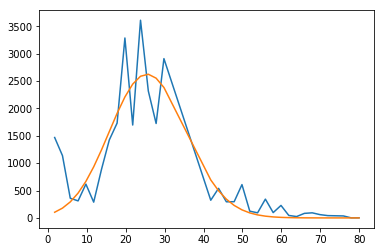

In [34]:
y=df_forfit[0].values
x1=df_forfit.index
o0=[20.,30.,5.]
errfunc = lambda o, x1, y: poisson(x1, o) - y # Distance to the target function, similar to def function.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y)) # p1 gives parameters
plt.figure()
plt.plot(x1,y)
plt.plot(x1,poisson(x1,o1))

In [35]:
Band10_20_avg_price_count=poisson(15,o1)
Band20_30_avg_price_count=poisson(25,o1)
Band30_40_avg_price_count=poisson(35,o1)
Band40_50_avg_price_count=poisson(45,o1)
print(Band10_20_avg_price_count,Band20_30_avg_price_count,Band30_40_avg_price_count,Band40_50_avg_price_count)

1443.348766927322 2621.6308949932695 1657.0752387815635 403.1995500209474


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


This has now be re-evaluated using a Poisson dist, it seems a little more accurate at least.

In [36]:
var1=Band30_40_avg_price_count/Band10_20_avg_price_count
var2=Band30_40_avg_price_count/Band20_30_avg_price_count
print(var1,var2)

1.1480768035775815 0.6320780098930814


Can create a very simple function based on the benchmarked sales, to apply to columns in a dataframe

In [38]:
def salescount(B12,B23):
    var1,var2=1.1480768035775815,0.6320780098930814
    return (var1*B12+var2*B23)/2.

This looks good, but might now be overestimating sales, Might try with fewer bins and play around until the distribution looks more representative. 

[[6.25412826e-04 6.11893727e-04 2.88141155e-01]
 [6.11893727e-04 6.00482471e-04 2.80465460e-01]
 [2.88141155e-01 2.80465460e-01 2.54091262e+02]] [6.56132916e+01 4.22618203e+01 1.00804632e+05]


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


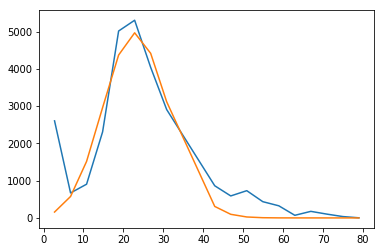

In [53]:
y,edges=np.histogram(data,bins=20)
x1=(edges+((edges[1]-edges[0])/2.0))[:-1]
df_forfit=pd.DataFrame(y,index=x1)
df_forfit=df_forfit[df_forfit[0]!=0]
y=df_forfit[0].values
x1=df_forfit.index
o0=[20.,30.,5.]
errfunc = lambda o, x1, y: poisson(x1, o) - y # Distance to the target function, similar to def function.
fulloutput = opt.leastsq(errfunc, o0[:], args=(x1, y), full_output=1) # p1 gives parameters
o1=fulloutput[0]
covmatrix=fulloutput[1]
print(covmatrix,o1)
plt.figure()
plt.plot(x1,y)
plt.plot(x1,poisson(x1,o1))

In [43]:
Band10_20_avg_price_count=poisson(15,o1)
Band20_30_avg_price_count=poisson(25,o1)
Band30_40_avg_price_count=poisson(35,o1)
Band40_50_avg_price_count=poisson(45,o1)
print(Band10_20_avg_price_count,Band20_30_avg_price_count,Band30_40_avg_price_count,Band40_50_avg_price_count)
var1=Band30_40_avg_price_count/Band10_20_avg_price_count
var2=Band30_40_avg_price_count/Band20_30_avg_price_count
print(var1,var2)

3044.592224549557 4797.870529898124 1719.1734202862924 169.65078039554226
0.5646645900308181 0.3583200942112118


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
